In [1]:
import pydicom
import nibabel as nib
import dicom2nifti
import os
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk

# Overlaying Original Scan and Binary Mask (infarct segment)

A few things:

** Original scan shape: 512,512,32 but the Binary mask shape: 512,512,31

** Please inspect Slice no. 12 and 13 to get the infarct area. 

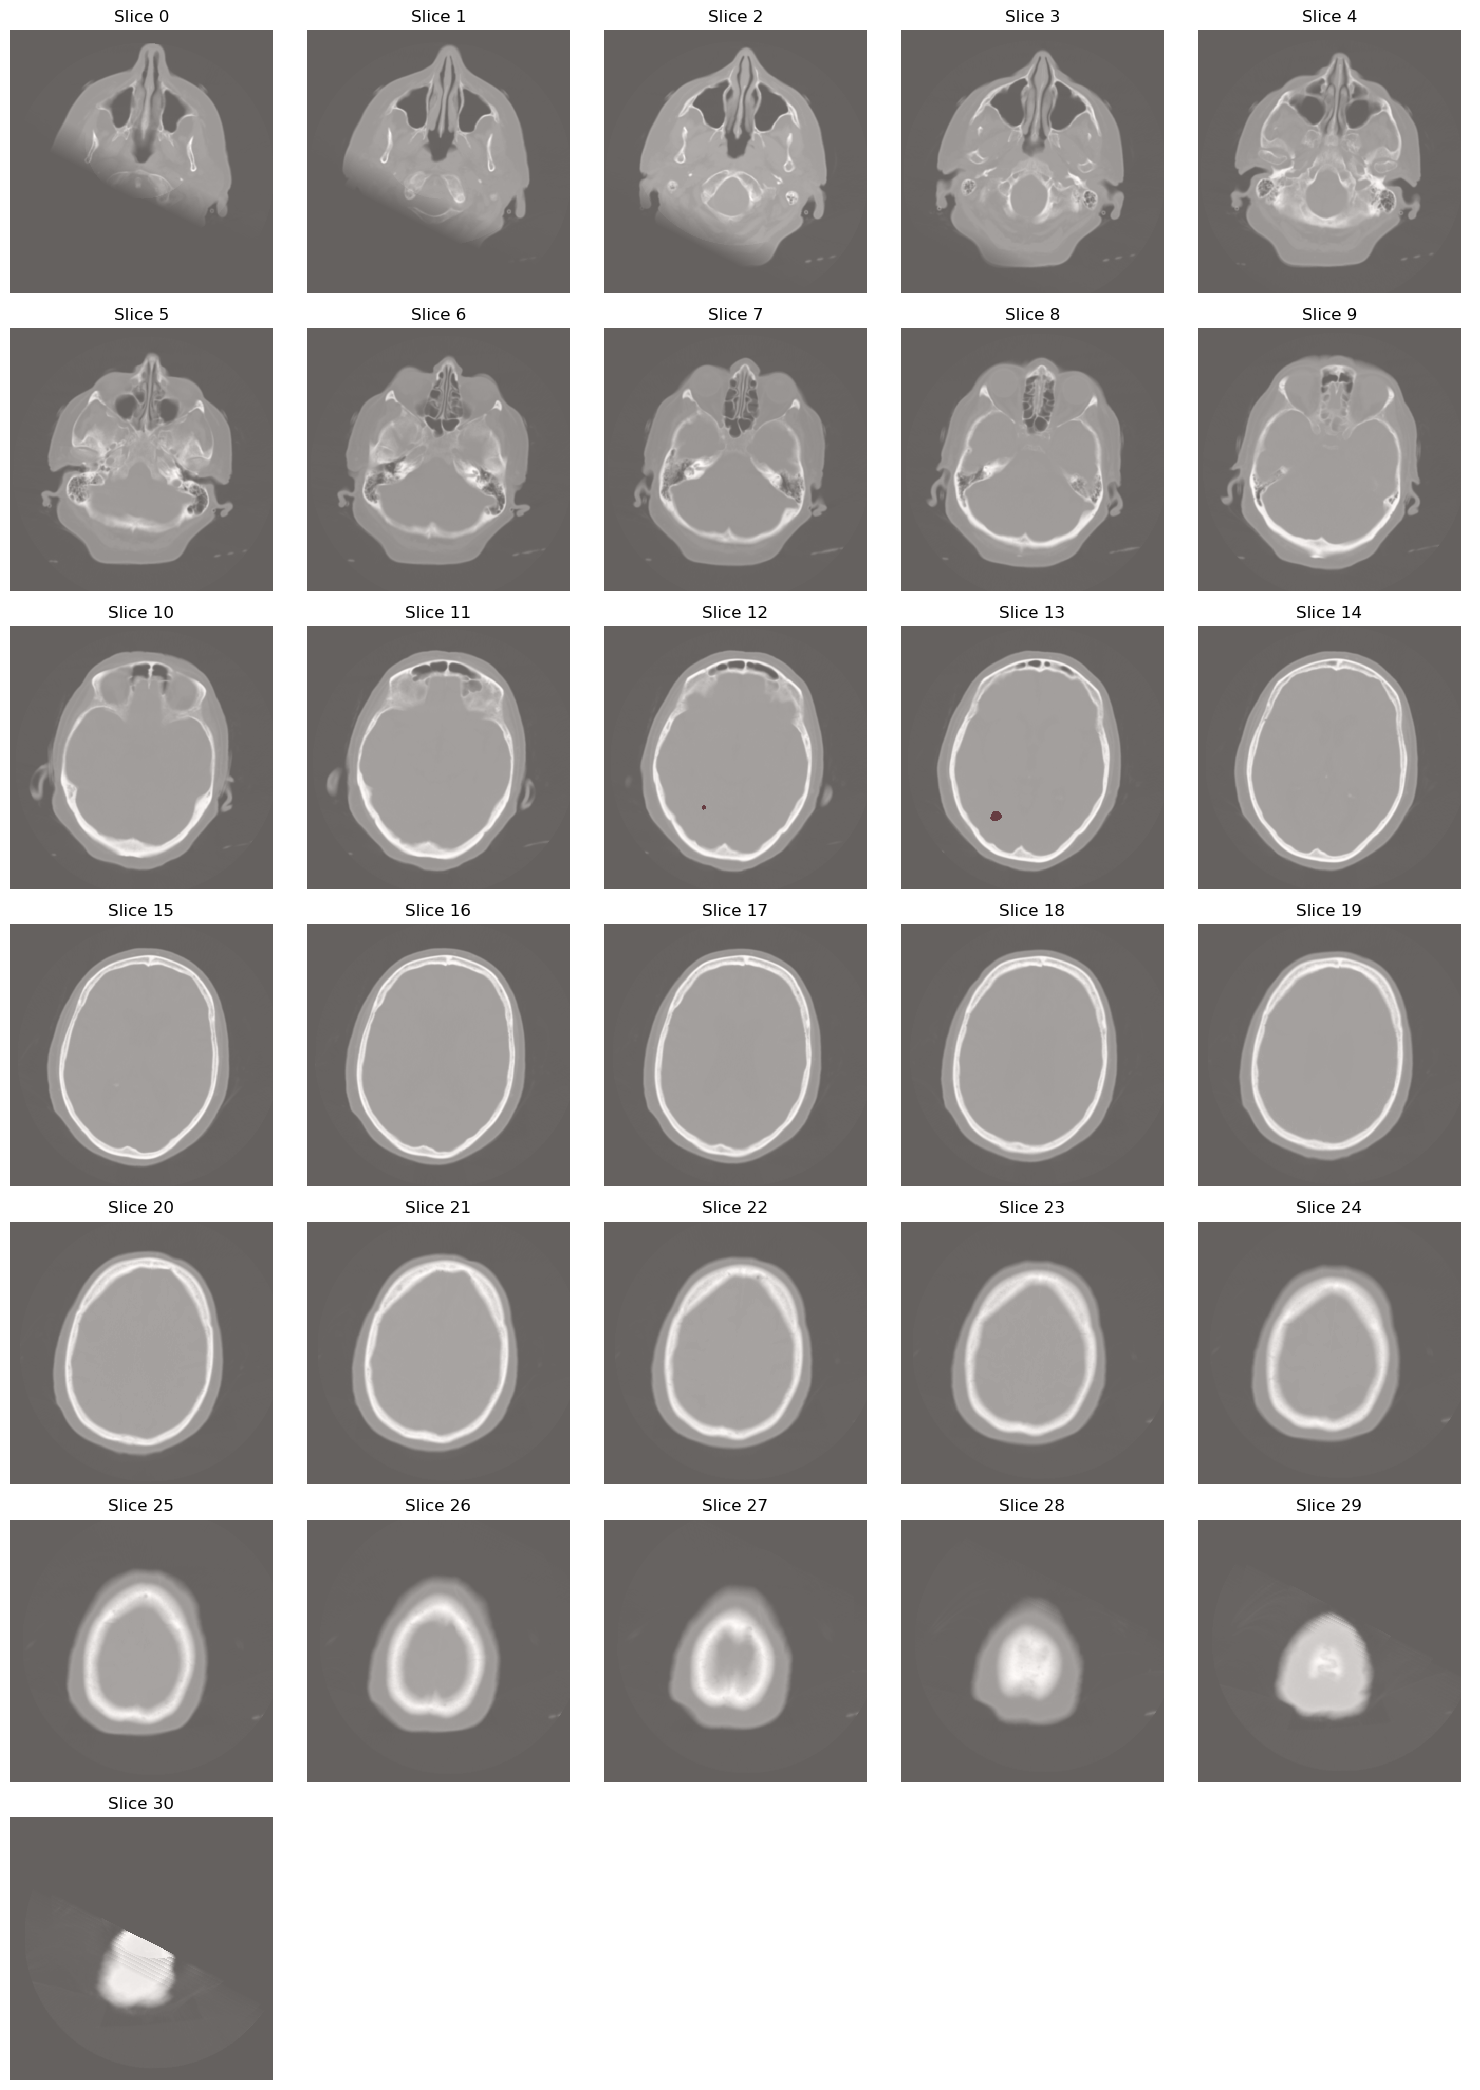

In [2]:
# Loading both original scan and mask for infarct segment
scan_path = r"C:\Users\anikd\Desktop\Stroke_Project\Sample_Data\original_scans_nifti\Escapena1_01-017_3252006300822273.nii.gz"
mask_path = r"C:\Users\anikd\Desktop\Stroke_Project\Sample_Data\segmentation\01-017seg.nii.gz"

scan = sitk.ReadImage(scan_path)
mask = sitk.ReadImage(mask_path)

# Converting to numpy arrays
scan_array = sitk.GetArrayFromImage(scan)  
mask_array = sitk.GetArrayFromImage(mask)

# Normalizing scan to [0, 1] for visualization
scan_array = (scan_array - np.min(scan_array)) / (np.max(scan_array) - np.min(scan_array))

scan_array = np.rot90(scan_array, k=3, axes=(1, 2))
mask_array = np.rot90(mask_array, k=3, axes=(1, 2))

# Determining the smaller number of slices
n_slices = min(scan_array.shape[0], mask_array.shape[0])

# Grid dimensions for visualization
n_cols = 5
n_rows = (n_slices + n_cols - 1) // n_cols

# Creating a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

# Plotting each slice
for i in range(n_slices):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.imshow(scan_array[i], cmap="gray", interpolation="none")
    ax.imshow(mask_array[i], cmap="Reds", alpha=0.4, interpolation="none")
    ax.axis("off")
    ax.set_title(f"Slice {i}")

# Hiding any empty subplots
for i in range(n_slices, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.axis("off")

plt.tight_layout()
plt.show()

# Mirroring the infarct area by Flipping the mask

Flipping the mask along left-right axis (horizontal) provided the mirrored mask. By applying the mirrored mask to the original scan will highlight the same amount of area but on the other side. 

* Red region: Infarct area
* Green region: Mirrored area

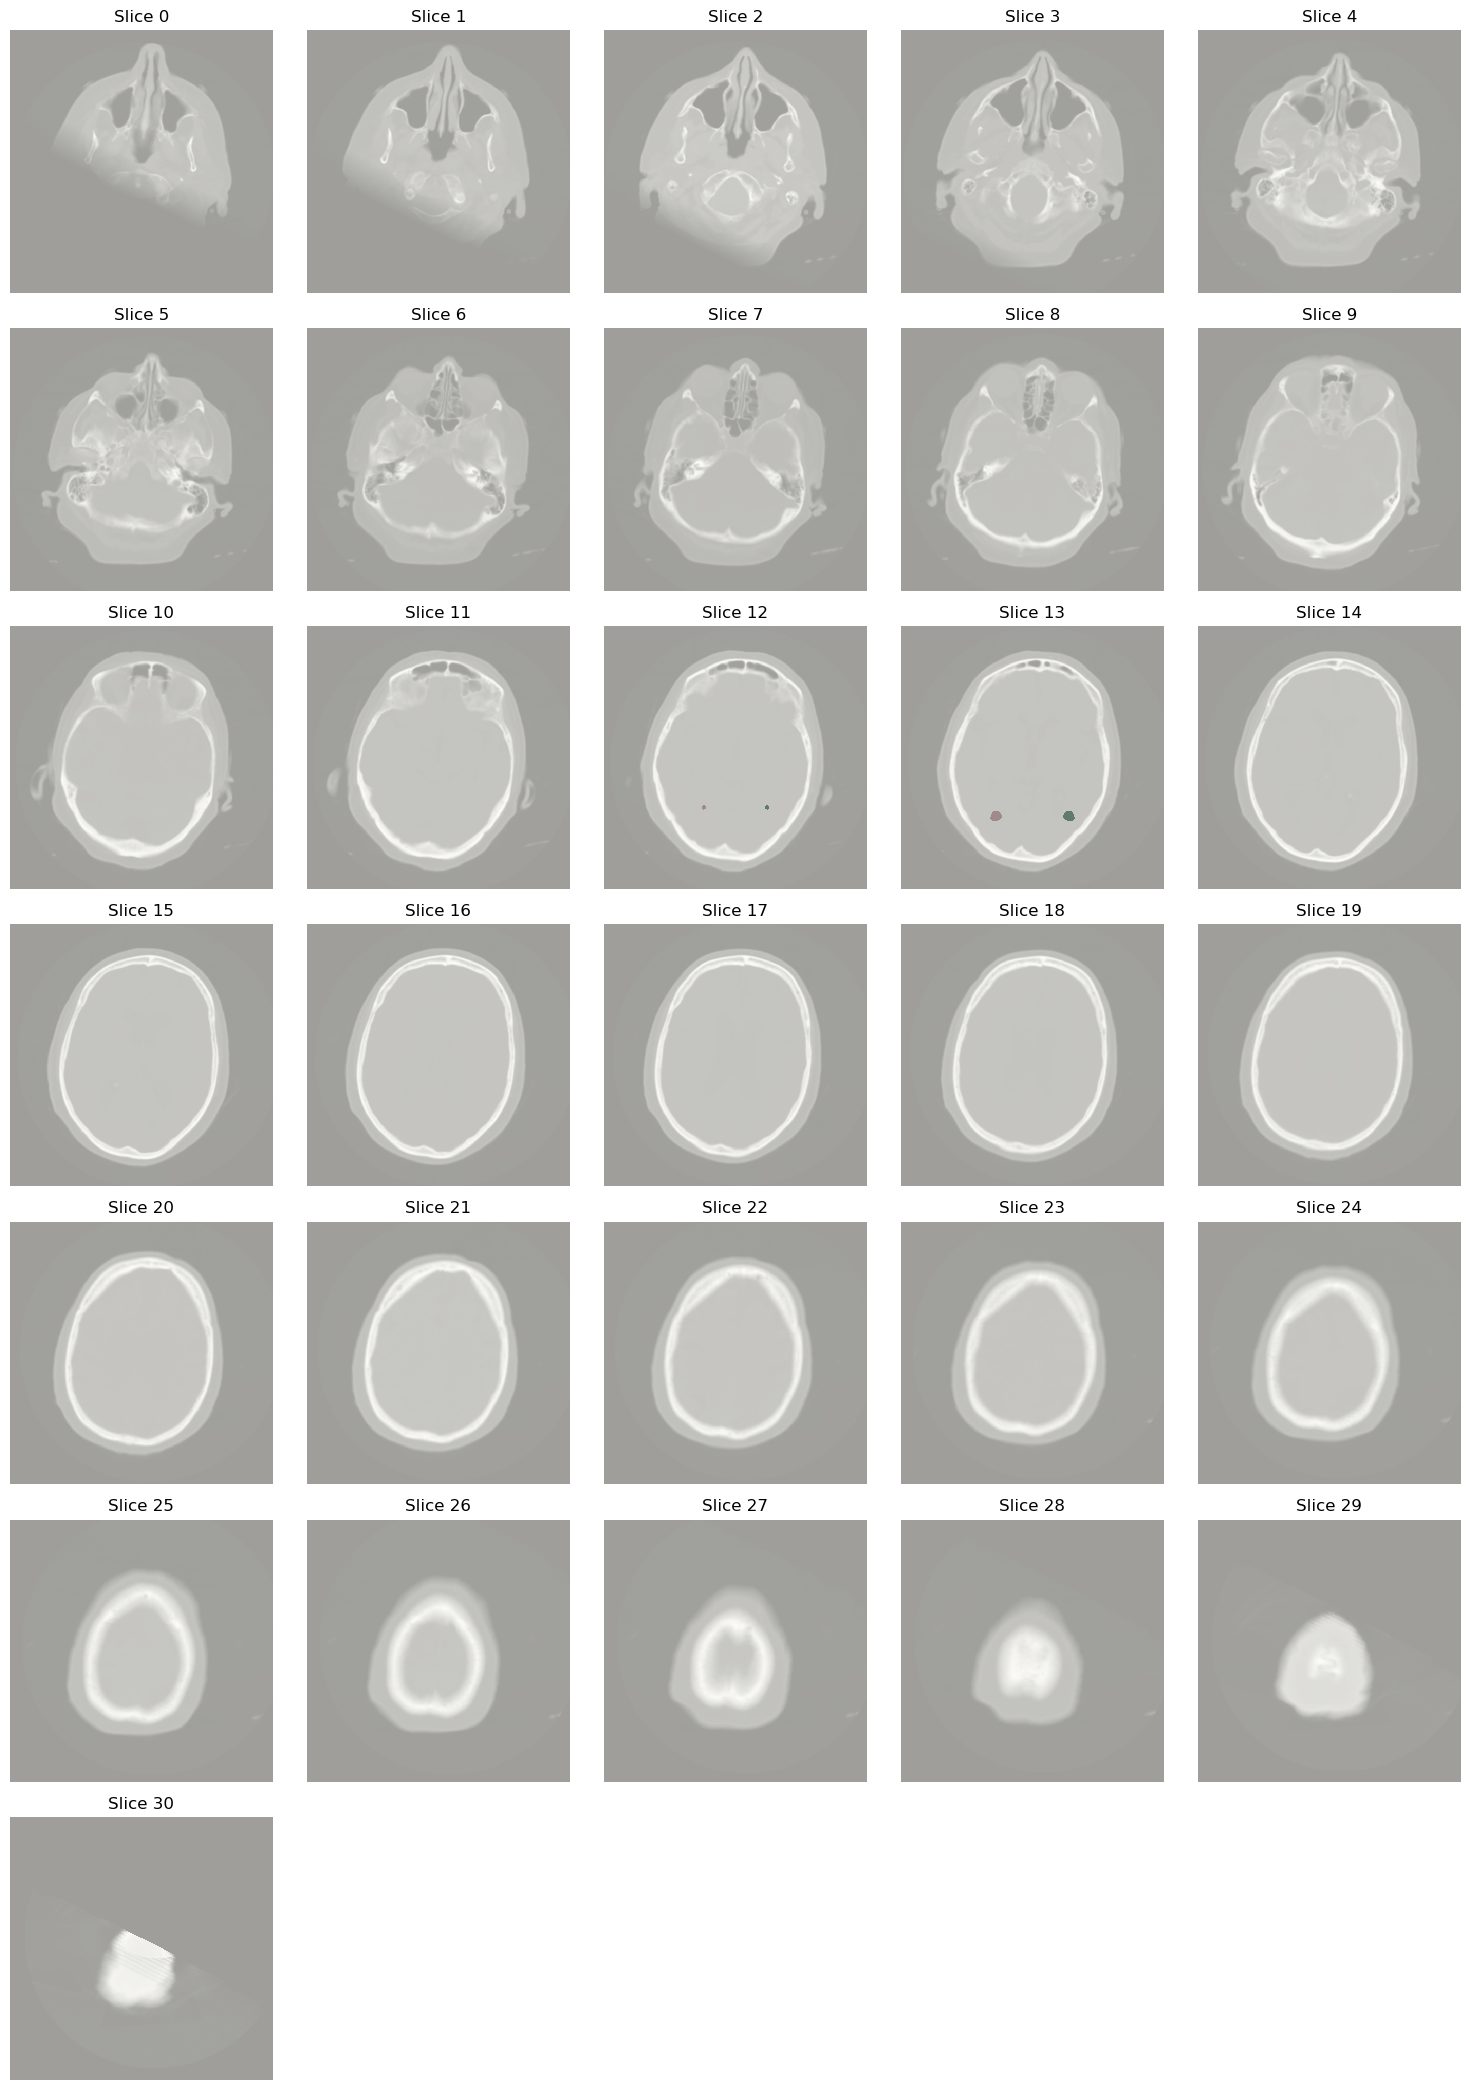

In [3]:
# Mirrorring the mask to the opposite side (flip along the horizontal axis)
mask_array_mirrored = np.flip(mask_array, axis=2)  # Flip left-right

# Creating a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

# Plotting each slice
for i in range(n_slices):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.imshow(scan_array[i], cmap="gray", interpolation="none")
    ax.imshow(mask_array[i], cmap="Reds", alpha=0.4, interpolation="none")  # Original infarct area in red
    ax.imshow(mask_array_mirrored[i], cmap="Greens", alpha=0.4, interpolation="none")  # Mirrored infarct area in green
    ax.axis("off")
    ax.set_title(f"Slice {i}")

# Hiding any empty subplots
for i in range(n_slices, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.axis("off")

plt.tight_layout()
plt.show()

# Calculating Mean and STD for Infarct area (red) and Mirrored area (green)

scan (depth, height, width): (32, 512, 512)
mask (depth, height, width): (31, 512, 512)

Since the slice number (depth) is not identical for original scan and mask, I trimmed the larger one to match with the least one.

$$ Can we consider reshaping here before performing any operation? Because, for other individuals, mask contains one slice less than original scan. However, as the difference is negligible, I just trimmed one slice from the original scan to match with mask.

In [4]:
# Trimming scan array to match mask array (vice-versa), Since the number of slice isn't similar for scan and mask.
if scan_array.shape[0] > mask_array.shape[0]:
    scan_array = scan_array[:mask_array.shape[0], :, :]
elif mask_array.shape[0] > scan_array.shape[0]:
    mask_array = mask_array[:scan_array.shape[0], :, :]

    
scan_infarct_area = scan_array * mask_array
scan_mirrored_area = scan_array * mask_array_mirrored

# Calculating mean and standard deviation for both segments
infarct_area_mean = np.mean(scan_infarct_area[scan_infarct_area > 0])
infarct_area_std = np.std(scan_infarct_area[scan_infarct_area > 0])

mirrored_area_mean = np.mean(scan_mirrored_area[scan_mirrored_area > 0])
mirrored_area_std = np.std(scan_mirrored_area[scan_mirrored_area > 0])

print(f"infarct area - Mean: {infarct_area_mean}, Standard Deviation: {infarct_area_std}")
print(f"Mirrored area - Mean: {mirrored_area_mean}, Standard Deviation: {mirrored_area_std}")

infarct area - Mean: 0.25723450912367785, Standard Deviation: 0.0008855863925271464
Mirrored area - Mean: 0.2572197463885121, Standard Deviation: 0.0012210407302010958
